# 20200515 Friday

# Generative Adversarial Networks

## Library & Hyper parameter setting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.utils as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

# hypter parameter setting
learning_rate = 2e-4
epochs = 200
batch_size = 32
display_step = 5

z_size = 50

device: gpu


## Load data and pre-process data

len(train_data):  60000
data tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, 

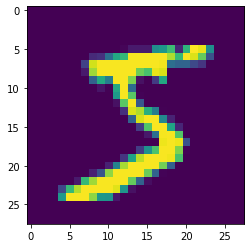

data shape: torch.Size([32, 1, 28, 28])
label: tensor([3, 5, 8, 8, 0, 7, 6, 3, 5, 6, 6, 1, 8, 5, 8, 9, 0, 1, 3, 8, 4, 1, 2, 1,
        9, 7, 6, 6, 4, 6, 1, 6])


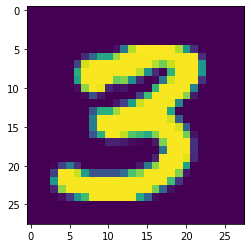

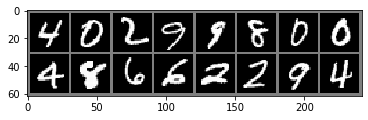

In [2]:
train_data = dataset.MNIST("./", train = True, transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   
                                         std=(0.5,))]), target_transform = None, download = True)

test_data = dataset.MNIST("./", train = False, transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   
                                         std=(0.5,))]), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))

x_train, y_train = train_data[0]
print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()


def imshow(img): #결과를 보여주는 함수
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): #결과를 보여주는 함수
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
(images, labels)  = next(iter(train_loader))
imshow_grid(images[0:16,:,:])

## Model & Optimization and Loss function

C:\Users\bj shin\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


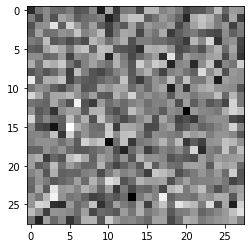

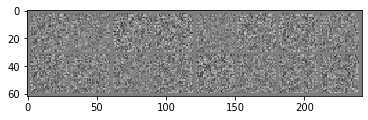

torch.Size([32, 784])
torch.Size([32, 1])
tensor([[0.5484, 0.5265, 0.5671, 0.5365, 0.5461, 0.5420, 0.5526, 0.5249, 0.5305,
         0.4996, 0.5732, 0.5402, 0.5405, 0.5092, 0.5651, 0.5281]],
       device='cuda:0', grad_fn=<TransposeBackward0>)


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_size, 256)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 28*28) #28*28과 z_size만 유의
        self.act3 = nn.Tanh()
    def forward(self, z):
        out = self.fc1(z)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)
        
        return out
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 1) # 마지막에 항상 1이어야한다.
        self.act3 = nn.Sigmoid()
  
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)
        
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight) #xavier_distribution에서 나오는 값으로 초기 웨이트 설정
        m.bias.data.fill_(0.01)
                
Generator = Generator()
Generator.apply(init_weights)
Generator.to(device)
Generator.train()

Discriminator = Discriminator()
Discriminator.apply(init_weights)
Discriminator.to(device)
Discriminator.train()

#optimizer는 전부 gradient 방식 (그 중 ADAM적용)
Generator_optimizer = torch.optim.Adam(Generator.parameters(), lr = learning_rate)
Discriminator_optimizer = torch.optim.Adam(Discriminator.parameters(), lr = learning_rate)

# make noise
z = torch.randn(1, z_size).to(device) # batch size, z size
# 가짜 이미지 생성하기
img_fake = Generator(z).view(-1,28,28) #784 vector를 24 x 24 matrix로 reshape
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = torch.randn(batch_size, z_size).to(device)
img_fake = Generator(z) # 32 x 784
img_fake = img_fake.reshape(32,28,28)
img_fake = img_fake.unsqueeze(1)
imshow_grid(img_fake[0:16,:,:])


print(Generator(z).shape)
print(Discriminator(Generator(z)).shape)
print(Discriminator(Generator(z)[0:16]).transpose(0,1))

## Train & Test

(epoch 1/200) D_loss: 0.484185, G_loss: 1.732046


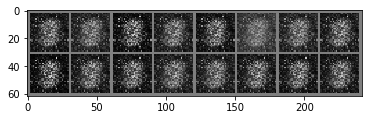

(epoch 6/200) D_loss: 0.443954, G_loss: 2.526951


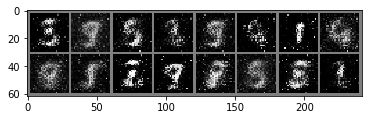

(epoch 11/200) D_loss: 0.739579, G_loss: 3.573759


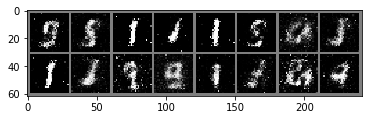

(epoch 16/200) D_loss: 0.766793, G_loss: 2.314837


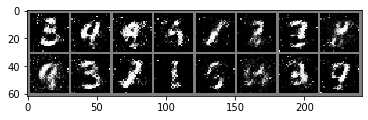

(epoch 21/200) D_loss: 0.851415, G_loss: 2.160957


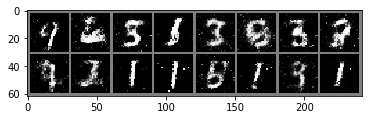

(epoch 26/200) D_loss: 1.069871, G_loss: 1.204959


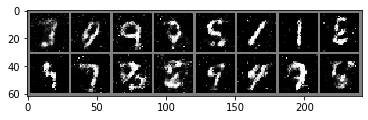

(epoch 31/200) D_loss: 0.920064, G_loss: 2.241781


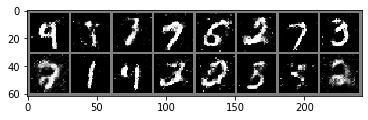

(epoch 36/200) D_loss: 0.869583, G_loss: 1.366073


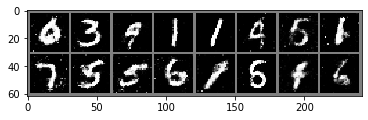

(epoch 41/200) D_loss: 0.977601, G_loss: 1.192032


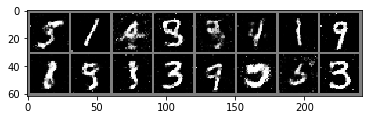

(epoch 46/200) D_loss: 1.071823, G_loss: 0.937358


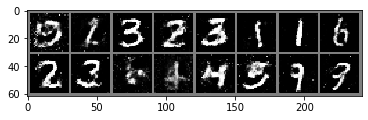

(epoch 51/200) D_loss: 0.975278, G_loss: 1.412492


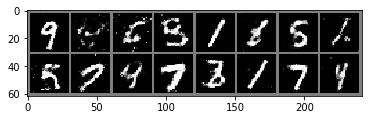

(epoch 56/200) D_loss: 0.969244, G_loss: 1.543404


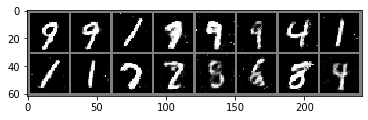

(epoch 61/200) D_loss: 0.985922, G_loss: 1.407441


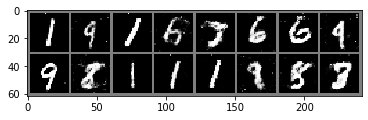

(epoch 66/200) D_loss: 1.006284, G_loss: 2.032954


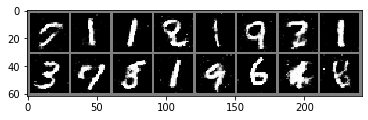

(epoch 71/200) D_loss: 0.788817, G_loss: 1.968447


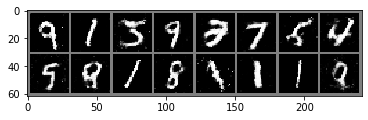

(epoch 76/200) D_loss: 0.703993, G_loss: 1.815285


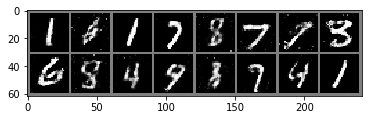

(epoch 81/200) D_loss: 1.057839, G_loss: 1.483909


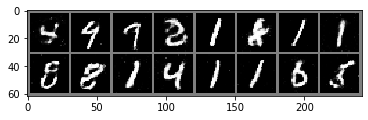

(epoch 86/200) D_loss: 1.022766, G_loss: 1.472410


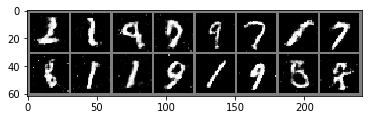

(epoch 91/200) D_loss: 0.884841, G_loss: 1.303021


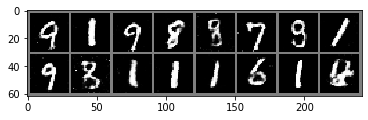

(epoch 96/200) D_loss: 1.013504, G_loss: 1.578027


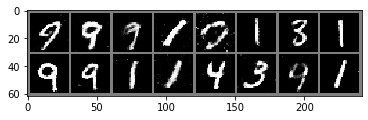

(epoch 101/200) D_loss: 0.779091, G_loss: 1.384584


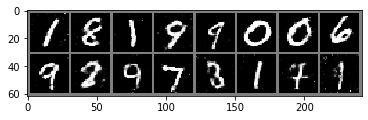

(epoch 106/200) D_loss: 0.707095, G_loss: 1.573391


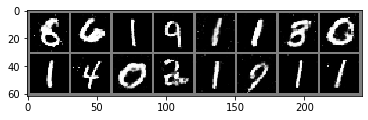

(epoch 111/200) D_loss: 0.685075, G_loss: 1.421184


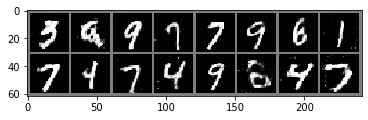

(epoch 116/200) D_loss: 0.931797, G_loss: 1.672615


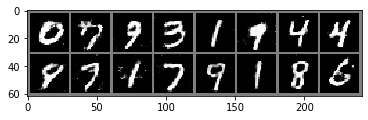

(epoch 121/200) D_loss: 0.743858, G_loss: 1.275024


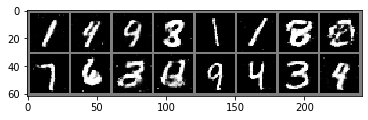

(epoch 126/200) D_loss: 1.093479, G_loss: 1.695268


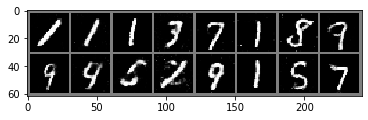

(epoch 131/200) D_loss: 1.028842, G_loss: 1.691463


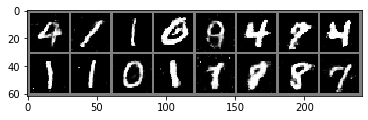

(epoch 136/200) D_loss: 0.771495, G_loss: 1.446172


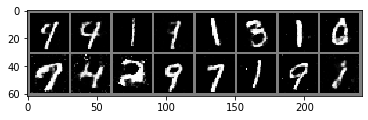

(epoch 141/200) D_loss: 0.986276, G_loss: 1.493531


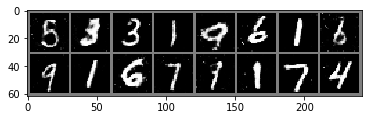

(epoch 146/200) D_loss: 0.921351, G_loss: 1.703959


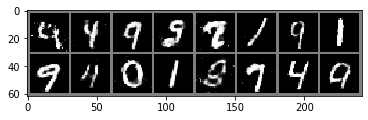

(epoch 151/200) D_loss: 0.735006, G_loss: 1.489257


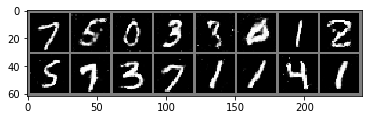

(epoch 156/200) D_loss: 0.953093, G_loss: 1.765962


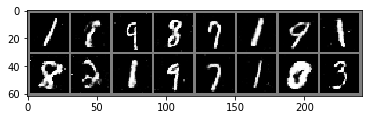

(epoch 161/200) D_loss: 0.852227, G_loss: 1.551001


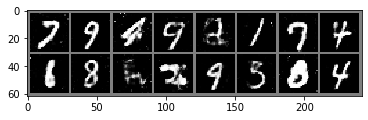

(epoch 166/200) D_loss: 0.970009, G_loss: 1.719979


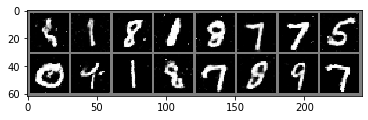

(epoch 171/200) D_loss: 1.042265, G_loss: 1.503043


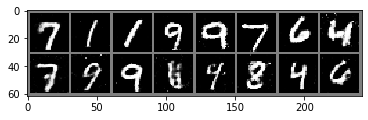

(epoch 176/200) D_loss: 0.944251, G_loss: 1.610570


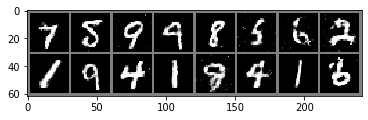

(epoch 181/200) D_loss: 0.847373, G_loss: 1.788238


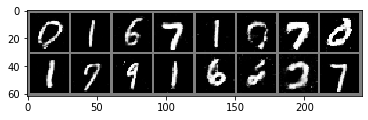

(epoch 186/200) D_loss: 0.913602, G_loss: 1.730560


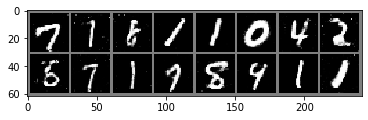

(epoch 191/200) D_loss: 0.863270, G_loss: 1.966959


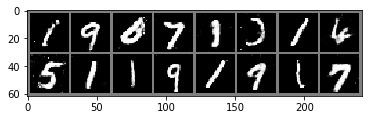

(epoch 196/200) D_loss: 1.089221, G_loss: 1.713885


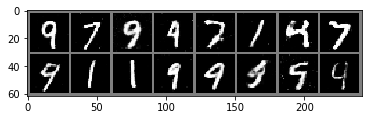

In [4]:
Discriminator_list = []
Generator_list = []

Generator.train()
Discriminator.train()

for epoch in range(epochs):    
    for iteration, (data, label) in enumerate(train_loader):
        
        data = data.to(device)
        label = label.to(device) 

        z = torch.randn(batch_size, z_size).to(device) #batch 30 z 50

        Discriminator_optimizer.zero_grad()

        D_real = Discriminator(data.view(-1, 28*28)) #32 x 28 x 28 = 32 x 784
        D_fake = Discriminator(Generator(z))

        Discriminator_loss = (-torch.log(D_real) - torch.log(1.- D_fake)).mean()
                
        Discriminator_loss.backward()
        Discriminator_optimizer.step() #디스크리미네이터에 파라미터 업데이트(Adam)

        Generator_optimizer.zero_grad()

        z = torch.randn(batch_size, z_size).to(device)
        D_fake = Discriminator(Generator(z))
                
        Generator_loss = -1 * torch.log(D_fake).mean() 
        Generator_loss.backward()
        Generator_optimizer.step()
        
        Discriminator_list.append(Discriminator_loss)
        Generator_list.append(Generator_loss)
        
        
#     D_real = (torch.sum(Discriminator(data.view(-1, 28*28))).item())
#     noise = torch.randn(batch_size, z_size).cuda()
#     D_fake = (torch.sum(Discriminator(Generator(noise))).item())

#     D_real_list.append(D_real)
#     D_fake_list.append(D_fake) 
    
    if(epoch % display_step == 0):
        z = torch.randn(16, z_size).to(device)
        print('(epoch %i/200) D_loss: %f, G_loss: %f' % (epoch+1, Discriminator_loss, Generator_loss))
        imshow_grid(Generator(z).view(-1, 1, 28, 28))